<a href="https://colab.research.google.com/github/1pawn0/time-series-forecasting-lab/blob/main/preprocessing_the_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
%pip install -qU plotly[express] jupyterlab anywidget kaleido
!plotly_get_chrome -y
!kaleido_get_chrome

Installing Chrome for Plotly...
Chrome installed successfully.
The Chrome executable is now located at: /usr/local/lib/python3.12/dist-packages/choreographer/cli/browser_exe/chrome-linux64/chrome
/usr/local/lib/python3.12/dist-packages/choreographer/cli/browser_exe/chrome-linux64/chrome


In [147]:
import numpy as np
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from datetime import datetime
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import SplineTransformer, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from statsmodels import tsa
from urllib.request import urlretrieve
from pathlib import Path
from tqdm.notebook import tqdm
from IPython.display import Image, display
import kaleido

pio.get_chrome()
kaleido.get_chrome_sync()


PosixPath('/usr/local/lib/python3.12/dist-packages/choreographer/cli/browser_exe/chrome-linux64/chrome')

### Download the csv dataset

In [148]:
from urllib.request import urlretrieve
from pathlib import Path

csv_url: str = "https://www.cryptodatadownload.com/cdd/Gemini_BTCUSD_1h.csv"
data_dir: Path = Path("./data")
data_dir.mkdir(exist_ok=True, parents=True)
csv_file: Path = data_dir / "Gemini_BTCUSD_1h.csv"

if not csv_file.exists():
    urlretrieve(csv_url, csv_file)
    print(f"CSV file downloaded to {csv_file}")
else:
    print(f"CSV file already exists at {csv_file}")

CSV file already exists at data/Gemini_BTCUSD_1h.csv


### Read the csv file as a Polars dataframe

In [149]:
import polars as pl

# Define the schema of df
df_schema: dict = {
    "date": pl.Datetime("ms"),
    "close": pl.Float64,
}
# Define which columns to load from the CSV
cols = list(df_schema.keys())
# Read the CSV file
df = (
    pl.read_csv(csv_file, columns=cols, skip_lines=1, schema_overrides=df_schema)
    .sort("date")
    .rename({"close": "price"})
)
# Fill the date gaps inside `df`
full_date_range = pl.datetime_range(
    start=df["date"][0],
    end=df["date"][-1],
    interval="1h",
    time_unit="ms",
    eager=True,
).to_frame(name="date")
df = full_date_range.join(df, on="date", how="left").interpolate().sort("date")
# Filter the dataset to only include data after a specific start date
df = df.filter(pl.col("date") > datetime(2016, 10, 30)).sort("date")
price_pct_changes_df = df.with_columns(
    pl.col("price").pct_change().shift(-1).alias("price_pct_change")
).sort("date")[:-1]
price_pct_changes_df

date,price,price_pct_change
datetime[ms],f64,f64
2016-10-30 01:00:00,695.23,0.014973
2016-10-30 02:00:00,705.64,0.003713
2016-10-30 03:00:00,708.26,-0.001398
2016-10-30 04:00:00,707.27,-0.000014
2016-10-30 05:00:00,707.26,0.0
…,…,…
2025-09-18 18:00:00,117889.1,-0.00294
2025-09-18 19:00:00,117542.48,0.000393
2025-09-18 20:00:00,117588.63,-0.002121


## Exploratory Data Analysis

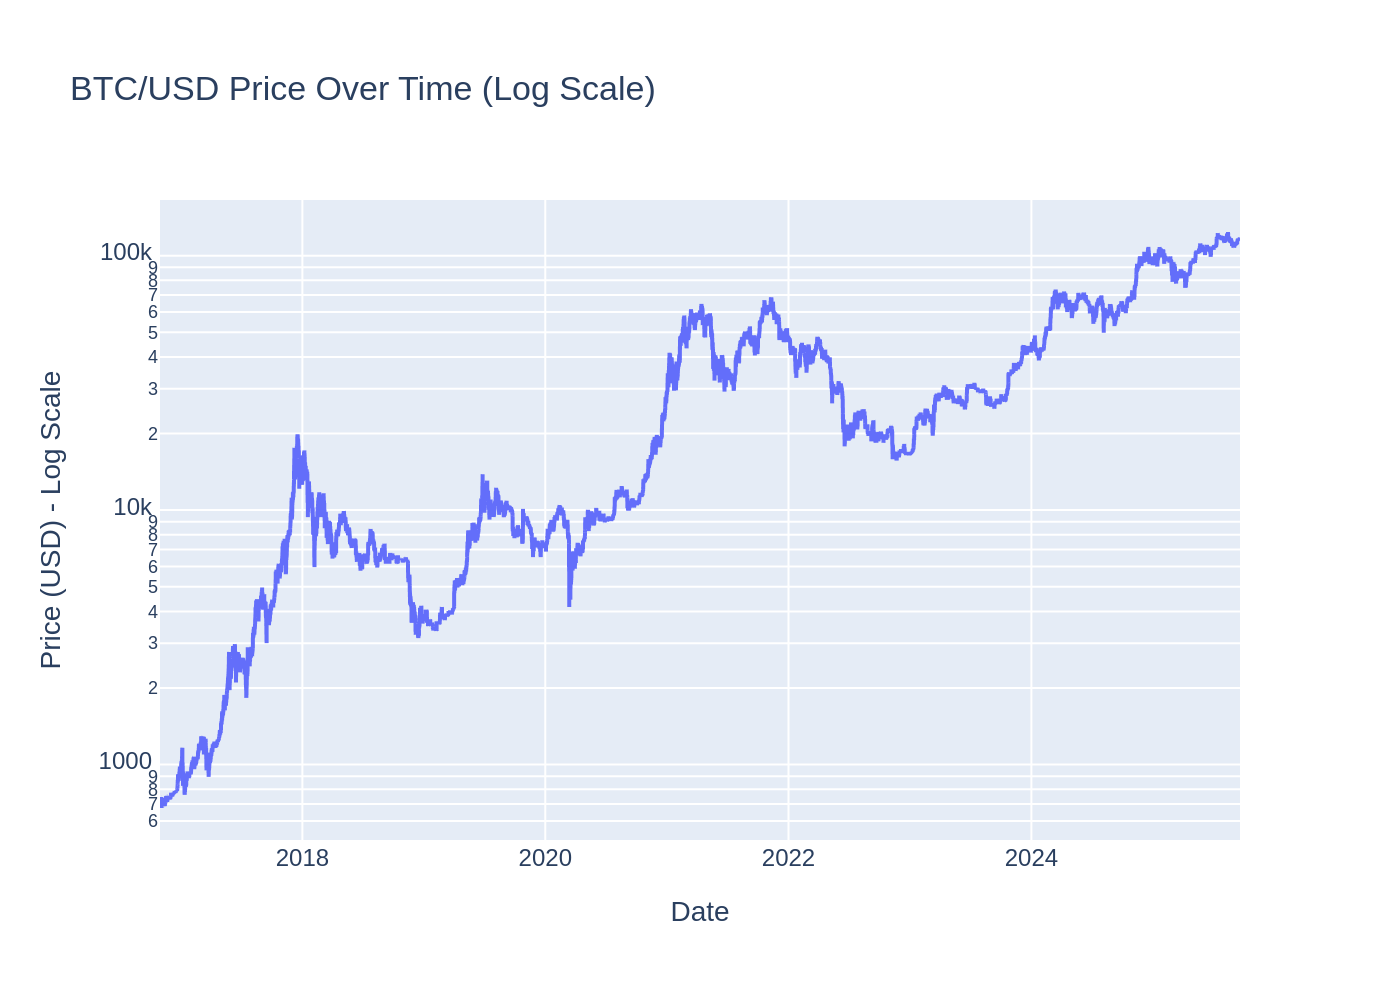

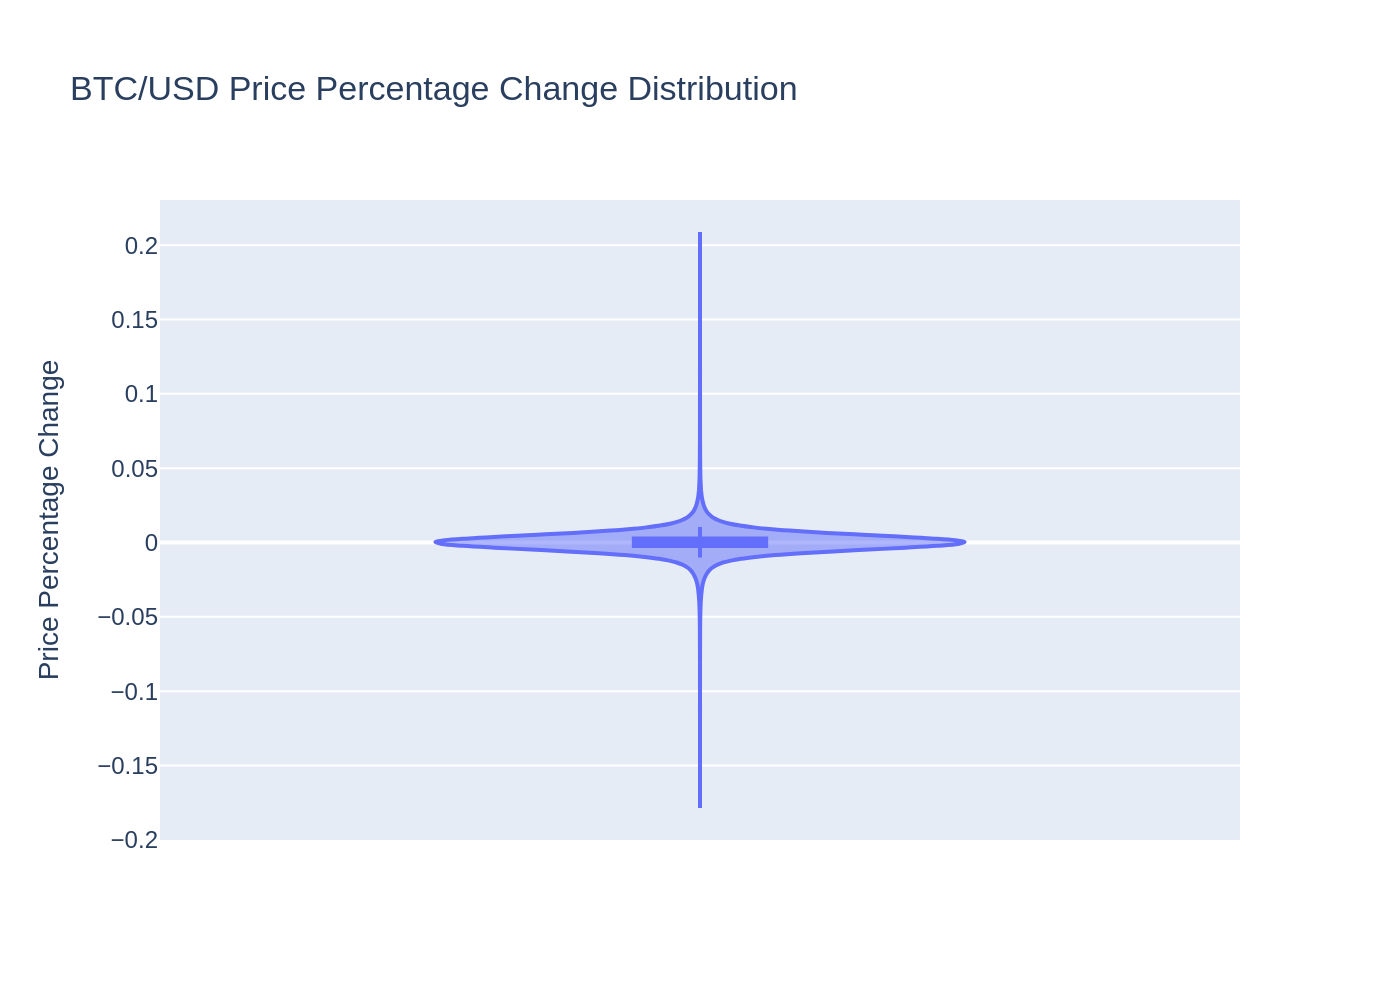

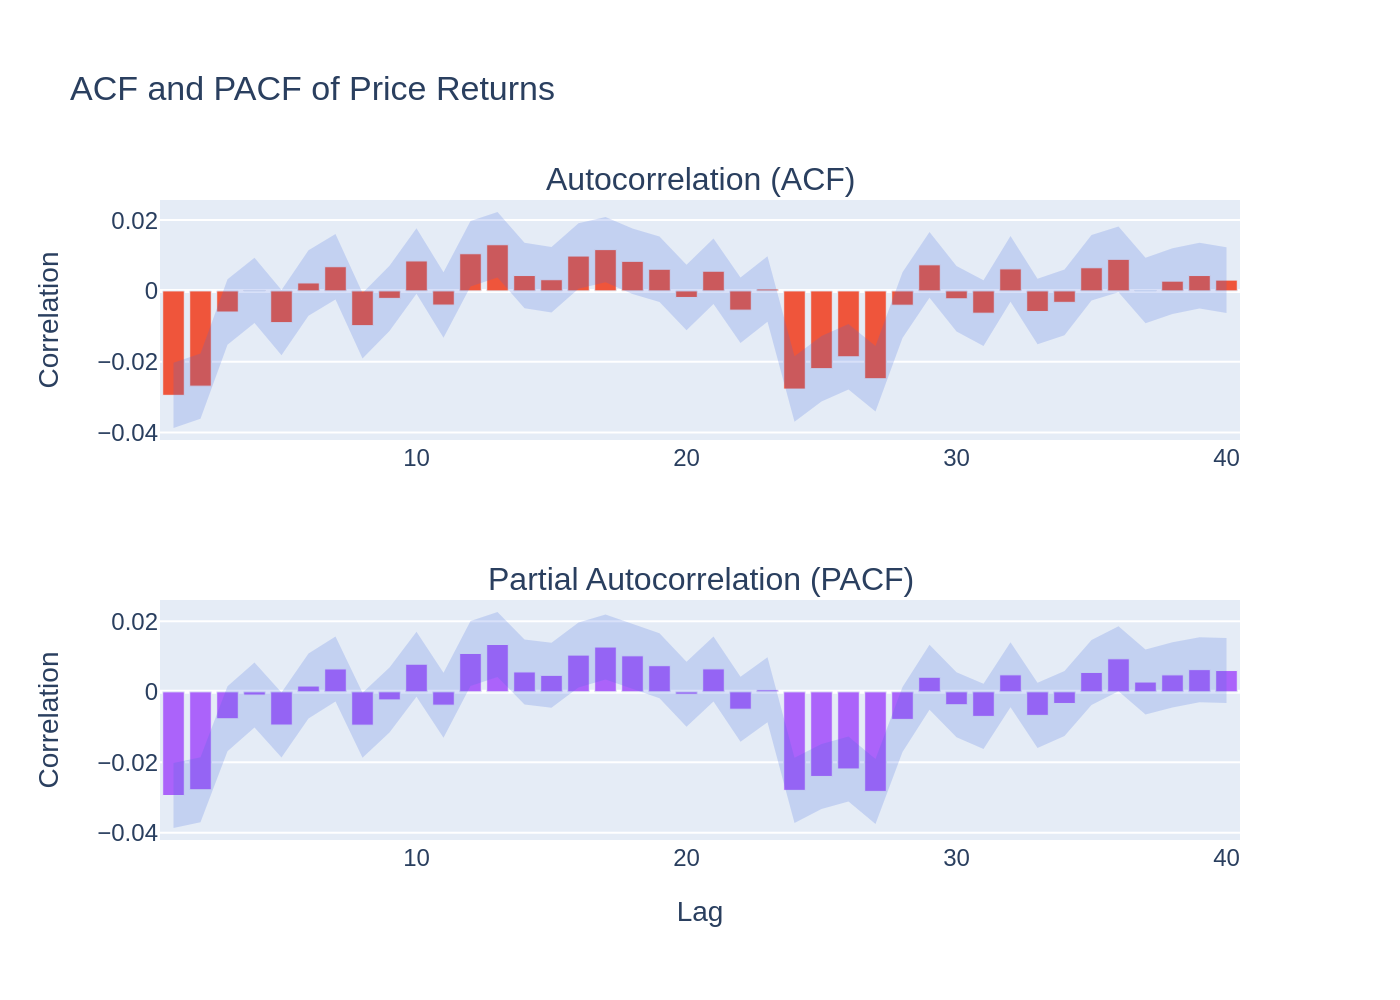

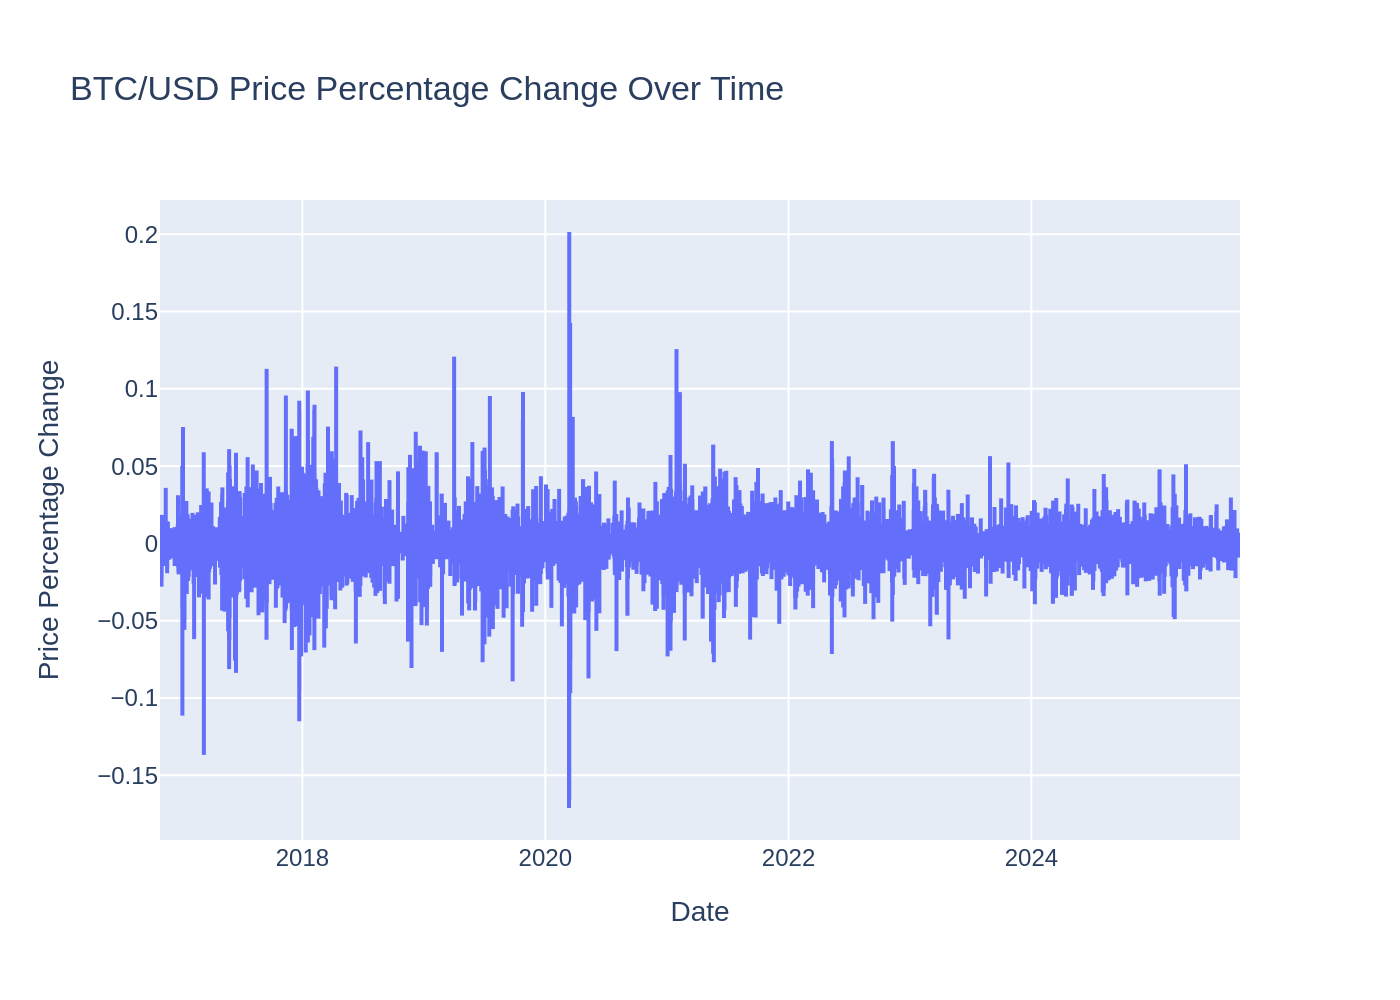

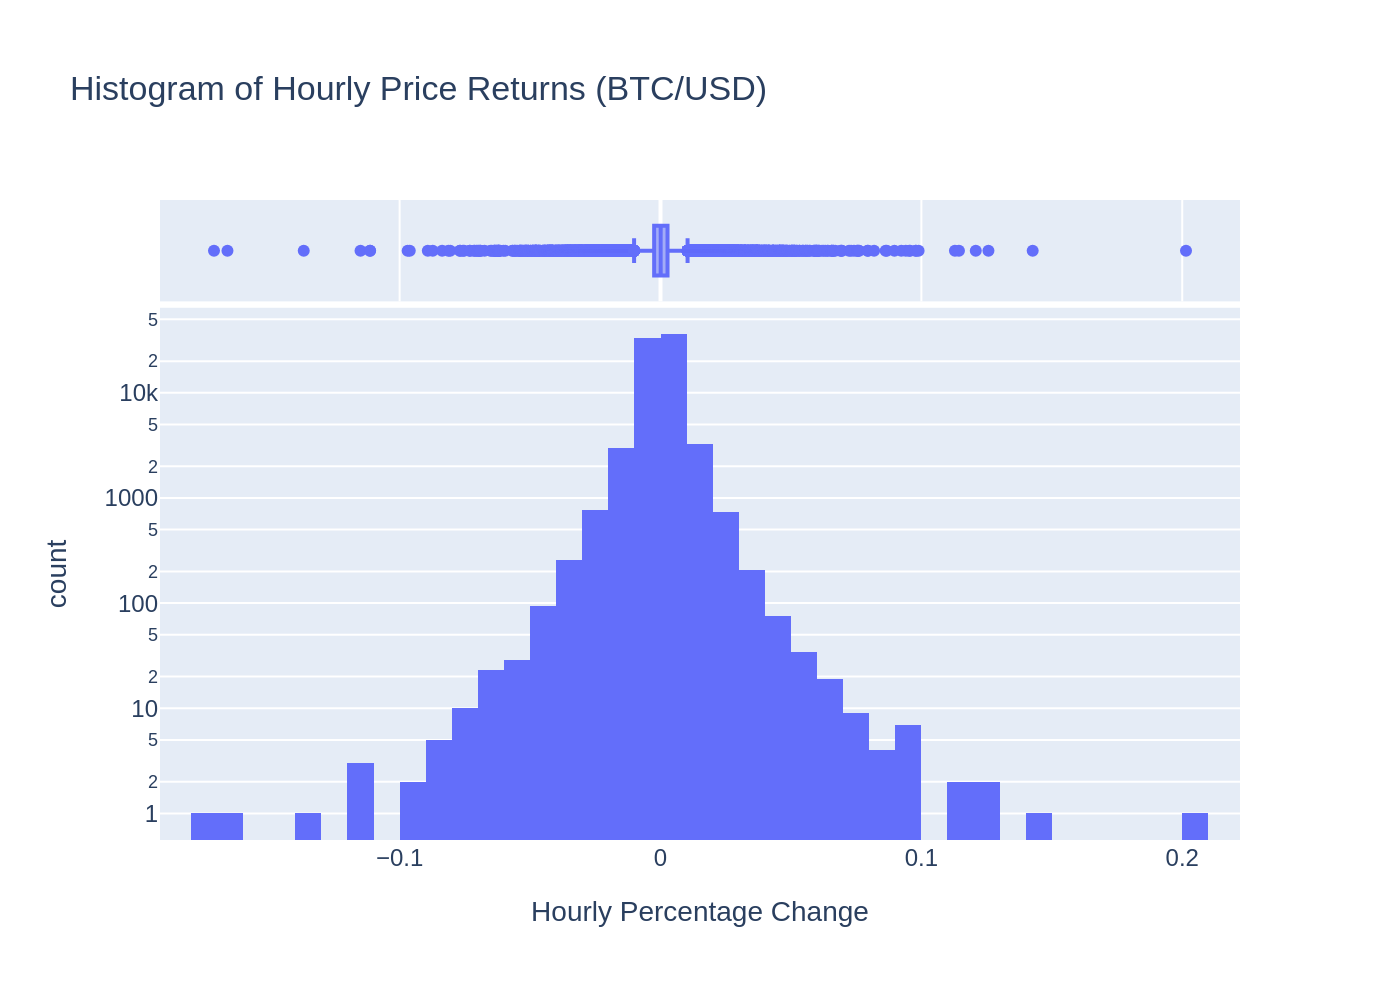

In [150]:
import plotly.express as px
import plotly.io as pio

figures: dict = {
    "price_lineplot": px.line(
        df[1:],
        x="date",
        y="price",
        log_y=True,
        title="BTC/USD Price Over Time (Log Scale)",
        labels={"date": "Date", "price": "Price (USD) - Log Scale"},
    ),
    "price_pct_changes_lineplot": px.line(
        price_pct_changes_df,
        x="date",
        y="price_pct_change",
        title="BTC/USD Price Percentage Change Over Time",
        labels={"date": "Date", "price_pct_change": "Price Percentage Change"},
    ),
    "price_pct_changes_violinplot": px.violin(
        price_pct_changes_df,
        y="price_pct_change",
        box=True,
        points=False,
        title="BTC/USD Price Percentage Change Distribution",
        labels={"price_pct_change": "Price Percentage Change"},
    ),
    "price_pct_changes_histogram": px.histogram(
        price_pct_changes_df,
        x="price_pct_change",
        nbins=40,
        marginal="box",
        log_y=True,
        title="Histogram of Hourly Price Returns (BTC/USD)",
        labels={"price_pct_change": "Hourly Percentage Change"},
    ),
}
plot_figures_path: Path = Path("./plot_figures")
pio.write_images(
    fig=list(figures.values()),
    file=[Path(plot_figures_path / f"{item}.png") for item in list(figures.keys())],
    format="png",
    scale=2,
)
for fig in plot_figures_path.iterdir():
    display(Image(fig))


In [151]:
from statsmodels.tsa.stattools import acf, pacf

N_LAGS, ALPHA_VALUE = 40, 0.01
acf_values, acf_conf_intervals, q_stat, p_values = acf(
    x=price_pct_changes_df["price_pct_change"],
    adjusted=False,
    nlags=N_LAGS,
    qstat=True,
    fft=False,
    alpha=ALPHA_VALUE,
)
acf_values = acf_values[1:]
acf_conf_intervals = acf_conf_intervals[1:]
q_stat = q_stat[1:]
p_values = p_values[1:]


pacf_values, pacf_conf_intervals = pacf(
    x=price_pct_changes_df["price_pct_change"],
    nlags=N_LAGS,
    method="ols-inefficient",
    alpha=ALPHA_VALUE,
)
pacf_values = pacf_values[1:]
pacf_conf_intervals = pacf_conf_intervals[1:]


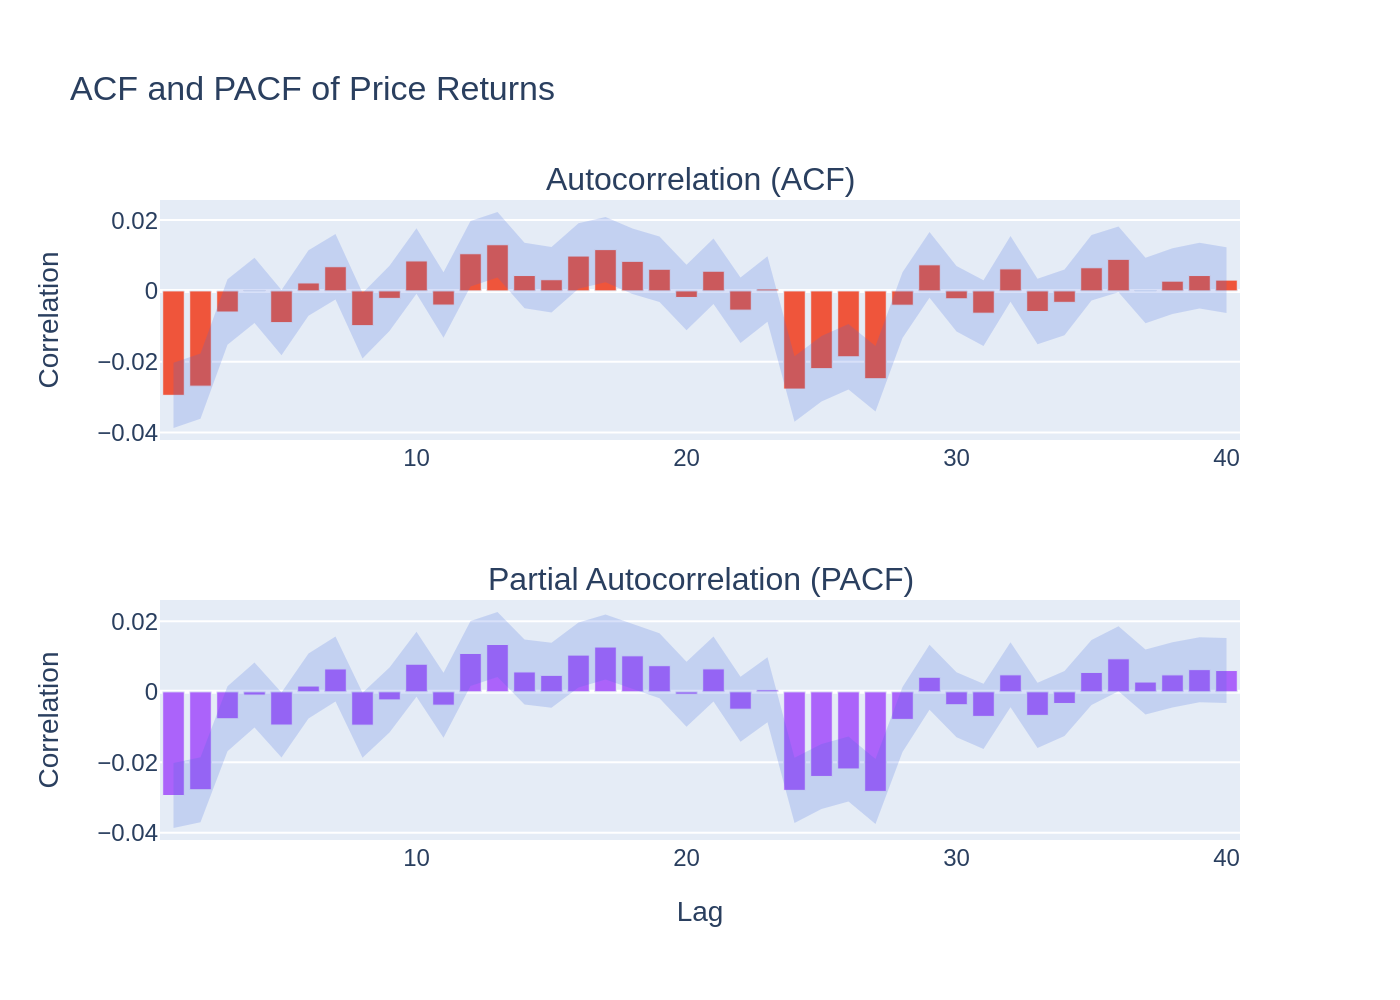

In [152]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create a figure
acf_pacf_fig = make_subplots(
    rows=2,
    cols=1,
    subplot_titles=("Autocorrelation (ACF)", "Partial Autocorrelation (PACF)"),
)

# Add ACF Plot to the First Row
lags_acf = np.arange(1, len(acf_values) + 1)
ci_upper_acf = acf_conf_intervals[:, 1]
ci_lower_acf = acf_conf_intervals[:, 0]

# Add ACF confidence interval region
acf_pacf_fig.add_trace(
    go.Scatter(
        x=np.concatenate([lags_acf, lags_acf[::-1]]),
        y=np.concatenate([ci_upper_acf, ci_lower_acf[::-1]]),
        fill="toself",
        fillcolor="RoyalBlue",
        opacity=0.2,
        line=dict(color="rgba(255,255,255,0)"),
        name="ACF 99% CI",
        showlegend=True,
    ),
    row=1,
    col=1,
)

# Add ACF bars
acf_pacf_fig.add_trace(go.Bar(x=lags_acf, y=acf_values, name="ACF"), row=1, col=1)


# Add PACF Plot to the Second Row
lags_pacf = np.arange(1, len(pacf_values) + 1)
ci_upper_pacf = pacf_conf_intervals[:, 1]
ci_lower_pacf = pacf_conf_intervals[:, 0]

# Add PACF confidence interval region
acf_pacf_fig.add_trace(
    go.Scatter(
        x=np.concatenate([lags_pacf, lags_pacf[::-1]]),
        y=np.concatenate([ci_upper_pacf, ci_lower_pacf[::-1]]),
        fill="toself",
        fillcolor="RoyalBlue",
        opacity=0.2,
        line=dict(color="rgba(255,255,255,0)"),
        name="PACF 99% CI",
        showlegend=True,
    ),
    row=2,
    col=1,
)

# Add PACF bars
acf_pacf_fig.add_trace(go.Bar(x=lags_pacf, y=pacf_values, name="PACF"), row=2, col=1)


acf_pacf_fig.update_layout(
    title_text="ACF and PACF of Price Returns",
    showlegend=False,
)

acf_pacf_fig.update_xaxes(title_text="Lag", row=2, col=1)
acf_pacf_fig.update_yaxes(title_text="Correlation", row=1, col=1)
acf_pacf_fig.update_yaxes(title_text="Correlation", row=2, col=1)

# acf_pacf_fig.show()
acf_pacf_fig.write_image(plot_figures_path / "acf_pacf_plot.png", format='png', scale=2)
display(Image(plot_figures_path / "acf_pacf_plot.png"))

## Preprocessing

### Create time-based features from the date.

In [153]:
prices = price_pct_changes_df.with_columns([
    pl.col("date").dt.year().alias("year"),
    pl.col("date").dt.month().alias("month"),
    pl.col("date").dt.day().alias("day"),
    pl.col("date").dt.hour().alias("hour"),
    pl.col("date").dt.weekday().alias("weekday"),
    pl.col("date").dt.week().alias("week"),
    pl.col("date").dt.quarter().alias("quarter"),
]).sort('date').drop("date")


### Create lagged features

In [154]:
hours: int = 27
expr_list: list[pl.Expr] = [pl.col("price_pct_change").shift(i).alias(f"pct_change_lag_{i}h") for i in range(1, hours + 1)]
lagged_df = prices.with_columns(expr_list).drop_nulls().drop('price')
lagged_df

price_pct_change,year,month,day,hour,weekday,week,quarter,pct_change_lag_1h,pct_change_lag_2h,pct_change_lag_3h,pct_change_lag_4h,pct_change_lag_5h,pct_change_lag_6h,pct_change_lag_7h,pct_change_lag_8h,pct_change_lag_9h,pct_change_lag_10h,pct_change_lag_11h,pct_change_lag_12h,pct_change_lag_13h,pct_change_lag_14h,pct_change_lag_15h,pct_change_lag_16h,pct_change_lag_17h,pct_change_lag_18h,pct_change_lag_19h,pct_change_lag_20h,pct_change_lag_21h,pct_change_lag_22h,pct_change_lag_23h,pct_change_lag_24h,pct_change_lag_25h,pct_change_lag_26h,pct_change_lag_27h
f64,i32,i8,i8,i8,i8,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.005869,2016,10,31,4,1,44,4,0.0,-0.00115,0.013736,-0.018515,0.001733,-0.002529,-0.005653,0.005327,-0.010023,-0.00182,-0.000014,-0.001831,0.006222,0.000567,-0.007013,0.004072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000014,-0.001398,0.003713,0.014973
0.0,2016,10,31,5,1,44,4,0.005869,0.0,-0.00115,0.013736,-0.018515,0.001733,-0.002529,-0.005653,0.005327,-0.010023,-0.00182,-0.000014,-0.001831,0.006222,0.000567,-0.007013,0.004072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000014,-0.001398,0.003713
-0.000558,2016,10,31,6,1,44,4,0.0,0.005869,0.0,-0.00115,0.013736,-0.018515,0.001733,-0.002529,-0.005653,0.005327,-0.010023,-0.00182,-0.000014,-0.001831,0.006222,0.000567,-0.007013,0.004072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000014,-0.001398
0.001245,2016,10,31,7,1,44,4,-0.000558,0.0,0.005869,0.0,-0.00115,0.013736,-0.018515,0.001733,-0.002529,-0.005653,0.005327,-0.010023,-0.00182,-0.000014,-0.001831,0.006222,0.000567,-0.007013,0.004072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000014
0.0,2016,10,31,8,1,44,4,0.001245,-0.000558,0.0,0.005869,0.0,-0.00115,0.013736,-0.018515,0.001733,-0.002529,-0.005653,0.005327,-0.010023,-0.00182,-0.000014,-0.001831,0.006222,0.000567,-0.007013,0.004072,0.0,0.0,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.00294,2025,9,18,18,4,38,3,0.001904,0.000236,0.000044,-0.000585,0.001805,0.002645,0.000628,-0.001044,-0.000767,0.000276,0.00129,0.000046,-0.00163,-0.003006,0.000461,0.005253,0.002752,0.002499,-0.000715,-0.001044,0.004505,0.003527,-0.000207,0.003792,-0.002778,-0.000952,-0.002173
0.000393,2025,9,18,19,4,38,3,-0.00294,0.001904,0.000236,0.000044,-0.000585,0.001805,0.002645,0.000628,-0.001044,-0.000767,0.000276,0.00129,0.000046,-0.00163,-0.003006,0.000461,0.005253,0.002752,0.002499,-0.000715,-0.001044,0.004505,0.003527,-0.000207,0.003792,-0.002778,-0.000952
-0.002121,2025,9,18,20,4,38,3,0.000393,-0.00294,0.001904,0.000236,0.000044,-0.000585,0.001805,0.002645,0.000628,-0.001044,-0.000767,0.000276,0.00129,0.000046,-0.00163,-0.003006,0.000461,0.005253,0.002752,0.002499,-0.000715,-0.001044,0.004505,0.003527,-0.000207,0.003792,-0.002778


### Split the data

In [155]:
# @title Split the test set
split_point = lagged_df.height - (hours ** 2)
train_df = lagged_df.slice(0,split_point)
test_df = lagged_df.slice(split_point, lagged_df.height)
X_test, y_test = test_df.drop('price_pct_change'), test_df['price_pct_change']
X_test.shape, y_test.shape, test_df.shape, train_df.shape, lagged_df.shape

((729, 34), (729,), (729, 35), (77146, 35), (77875, 35))

In [156]:
# @title Split the train and validation sets
from sklearn.model_selection import train_test_split
X = train_df.drop('price_pct_change')
y = train_df['price_pct_change']
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

###

In [157]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer
from sklearn.compose import make_column_transformer


